# Pretrained MNIST

## Importing required packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from  torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim
from torchvision import datasets,transforms
from pytorch_lightning import seed_everything
import pytorch_lightning as pl
import pandas as pd
import random


from sklearn.manifold import TSNE
from enum import auto
from sklearn.decomposition import PCA
import seaborn as sns

import torch.nn.init as init


/Users/federicoferoggio/Documents/vs_code/latent-communication/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining transforms

In [2]:
transforms=transforms.ToTensor()

## Downloading requried data

In [3]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transforms)
test_data=datasets.MNIST('data',train=False,download=True,transform=transforms)

## Defining dataloaders

In [4]:
valid_size=0.2

# IMPORTANT 
batch_size=20

num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [5]:

# Printing the length of our train, valid and test dataloaders
# NOTE : Here batch size is 20
len(train_loader),len(valid_loader),len(test_loader)

(2400, 600, 500)

In [6]:
# Iterate over the data loader to get a batch of data
dataiter = iter(train_loader)

# Print the data iterator
print("Data Iterator:", dataiter)

# Get the next batch of images and labels
images, labels = next(dataiter)

# Print information about the images
print("Images:")
print(images)
print("Shape:", images.shape)
print("Number of Images:", len(images))
print("Shape of First Image:", images[0].shape)
print()

# Print information about the labels
print("Labels:")
print(labels)
print("Shape:", labels.shape)
print("Number of Labels:", len(labels))


Data Iterator: <torch.utils.data.dataloader._SingleProcessDataLoaderIter object at 0x31b734a40>
Images:
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..

## Visualizing a Training batch

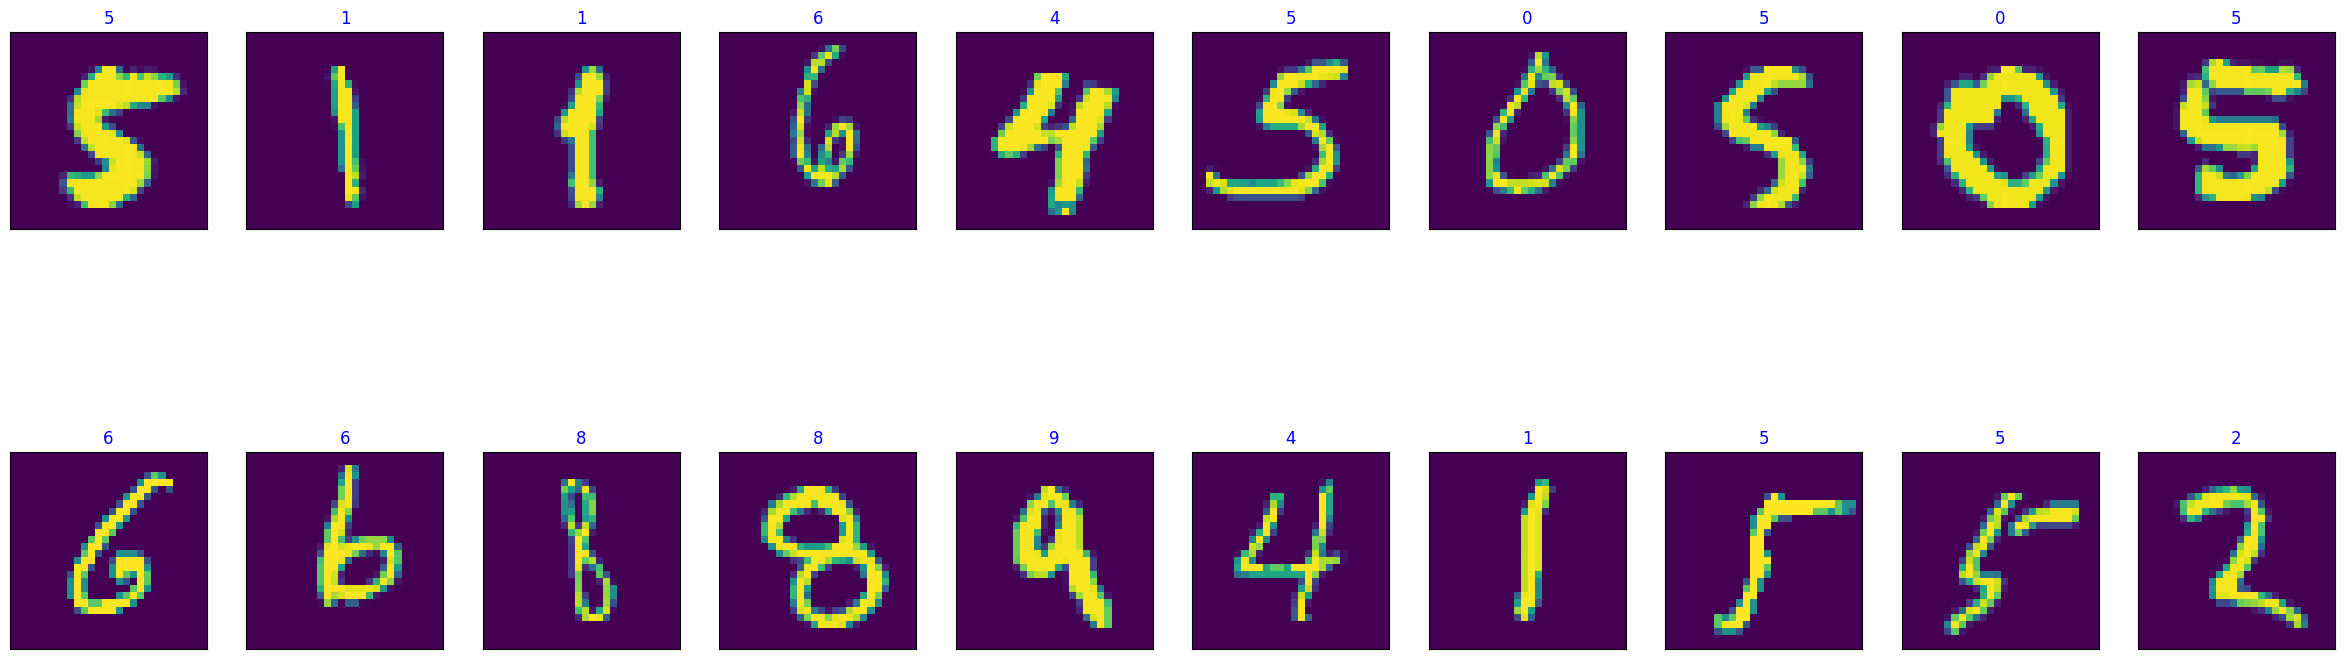

In [7]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue')

# Encoder/Decoder Seperation

## Defining Architecture

In [8]:
class LightningAutoencoder(pl.LightningModule):
    import torch.nn.init as init
    def __init__(self):
        super().__init__()
        self.autoencoder = nn.Module()
        self.autoencoder.encoder = nn.ModuleList([
        nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),),
        nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU()),
        nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU()),
        nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
        )])
        self.autoencoder.decoder = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(128),
                nn.GELU()),
            nn.Sequential(
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.GELU()),
            nn.Sequential(
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(32),
                nn.GELU()),
            nn.Sequential(
                nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(32),
                nn.GELU()),
            nn.Sequential(
                nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
                nn.Sigmoid()),
        ])
        self.autoencoder.encoder_out = nn.Sequential(
            nn.Linear(1024, 500),
            nn.GELU(),
        )
        self.autoencoder.decoder_in = nn.Sequential(
            nn.Linear(500, 1024),
            nn.GELU(),
        )

    def forward(self, x):
        for layer in self.autoencoder.encoder:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.autoencoder.encoder_out(x)
        x = self.autoencoder.decoder_in(x)
        x = x.view(x.size(0), 256, 2, 2)
        for layer in self.autoencoder.decoder:
            x = layer(x)
        return x

    def init_weights(self, m):
        if type(m) == nn.Linear:
            init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)
    

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [9]:
state_dict = torch.load('/Users/federicoferoggio/Documents/vs_code/latent-communication/autoencoder/LightningAutoencoder.pth')
model_4 = LightningAutoencoder()

new_state_dict = {k: v for k, v in state_dict.items() if k in model_4.state_dict()}
print(new_state_dict.keys())

model_4.load_state_dict(new_state_dict, strict=False)

#print(model_0,'\n\n\n\n',model_1,'\n\n\n\n',model_2,'\n\n\n\n',model_3, model_4,'\n\n\n\n','On GPU : ',torch.cuda.is_available())
#print(model_1,'\n\n\n\n',model_2,'\n\n\n\n',model_3,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

dict_keys(['autoencoder.encoder.0.0.weight', 'autoencoder.encoder.0.0.bias', 'autoencoder.encoder.0.1.weight', 'autoencoder.encoder.0.1.bias', 'autoencoder.encoder.0.1.running_mean', 'autoencoder.encoder.0.1.running_var', 'autoencoder.encoder.0.1.num_batches_tracked', 'autoencoder.encoder.1.0.weight', 'autoencoder.encoder.1.0.bias', 'autoencoder.encoder.1.1.weight', 'autoencoder.encoder.1.1.bias', 'autoencoder.encoder.1.1.running_mean', 'autoencoder.encoder.1.1.running_var', 'autoencoder.encoder.1.1.num_batches_tracked', 'autoencoder.encoder.2.0.weight', 'autoencoder.encoder.2.0.bias', 'autoencoder.encoder.2.1.weight', 'autoencoder.encoder.2.1.bias', 'autoencoder.encoder.2.1.running_mean', 'autoencoder.encoder.2.1.running_var', 'autoencoder.encoder.2.1.num_batches_tracked', 'autoencoder.encoder.3.0.weight', 'autoencoder.encoder.3.0.bias', 'autoencoder.encoder.3.1.weight', 'autoencoder.encoder.3.1.bias', 'autoencoder.encoder.3.1.running_mean', 'autoencoder.encoder.3.1.running_var', 'aut

<All keys matched successfully>

## Defining our Loss Function

In [10]:
# Used when comapring pixel values.
criterion=nn.MSELoss()

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Training and Validation Phase

In [11]:
from lightning.pytorch.callbacks import ModelCheckpoint

from lightning.pytorch import seed_everything

print('bau')

seeds = [12345, 100000000, 100]
for i, seed in enumerate(seeds):
    print(seed)
    seed_everything(seed)
    set_random_seed(seed)
    model = LightningAutoencoder()
    model.apply(model.init_weights)
    model.train()
    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(model, train_loader, valid_loader)
    trainer.save_checkpoint(f'LightningAutoencoder_{i}.ckpt')

# def trainNet(model, path):
#     checkpoint_callback = ModelCheckpoint(dirpath="", save_top_k=2, monitor="val_loss")
#     model.train() # TURN ON DROPOUT for training
#     trainer = pl.Trainer(max_epochs=3)
#     trainer.fit(model, train_loader, valid_loader)

Seed set to 12345


bau
12345


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/federicoferoggio/Documents/vs_code/latent-communication/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/federicoferoggio/Documents/vs_code/latent-communication/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name        | Type   | P

Epoch 9: 100%|██████████| 2400/2400 [01:08<00:00, 34.89it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2400/2400 [01:08<00:00, 34.83it/s, v_num=4]


Seed set to 100000000
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


100000000



  | Name        | Type   | Params
---------------------------------------
0 | autoencoder | Module | 2.1 M 
---------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.250     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 2400/2400 [01:11<00:00, 33.69it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2400/2400 [01:11<00:00, 33.65it/s, v_num=5]


Seed set to 100


100


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type   | Params
---------------------------------------
0 | autoencoder | Module | 2.1 M 
---------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.250     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 2400/2400 [01:12<00:00, 33.16it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2400/2400 [01:12<00:00, 33.11it/s, v_num=6]


In [12]:
#m4_loss = trainNet(model_4,0.01, 'conv')

## Plotting Loss

In [13]:
!tensorboard --logdir lightning_logs/

Traceback (most recent call last):
  File "/Users/federicoferoggio/Library/Python/3.9/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/Users/federicoferoggio/Library/Python/3.9/lib/python/site-packages/tensorboard/main.py", line 26, in <module>
    from absl import app
ModuleNotFoundError: No module named 'absl'


## Testing Phase

In [14]:
def test(model,state='fully'):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    if state=='fully':
        images = images.view(images.size(0), -1)

    # get sample outputs
    output = model(images)
    # prep images for display
    images = images.cpu().numpy()
    # output is resized into a batch of images
    output = output.view(batch_size, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.cpu().detach().numpy()


    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            if state=='fully':
                img = img.reshape(1, 28, 28)
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            

## Pretrained Autoencoder

In [15]:
model_1 = LightningAutoencoder.load_from_checkpoint(checkpoint_path='LightningAutoencoder_0.ckpt')
model_2 = LightningAutoencoder.load_from_checkpoint(checkpoint_path='LightningAutoencoder_1.ckpt')
model_3 = LightningAutoencoder.load_from_checkpoint(checkpoint_path='LightningAutoencoder_2.ckpt')


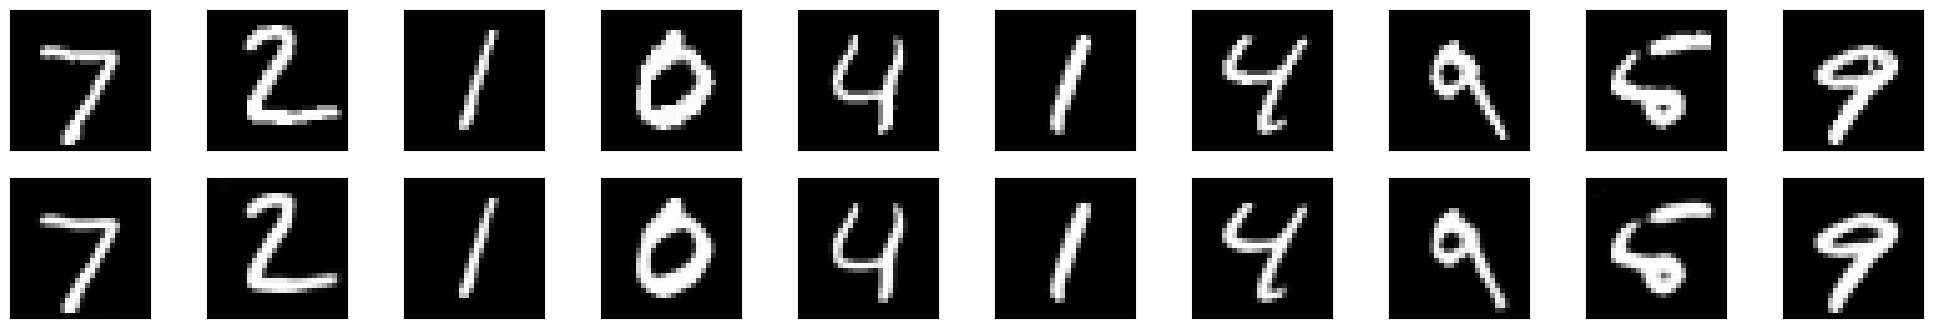

In [16]:
test(model_1, 'conv')

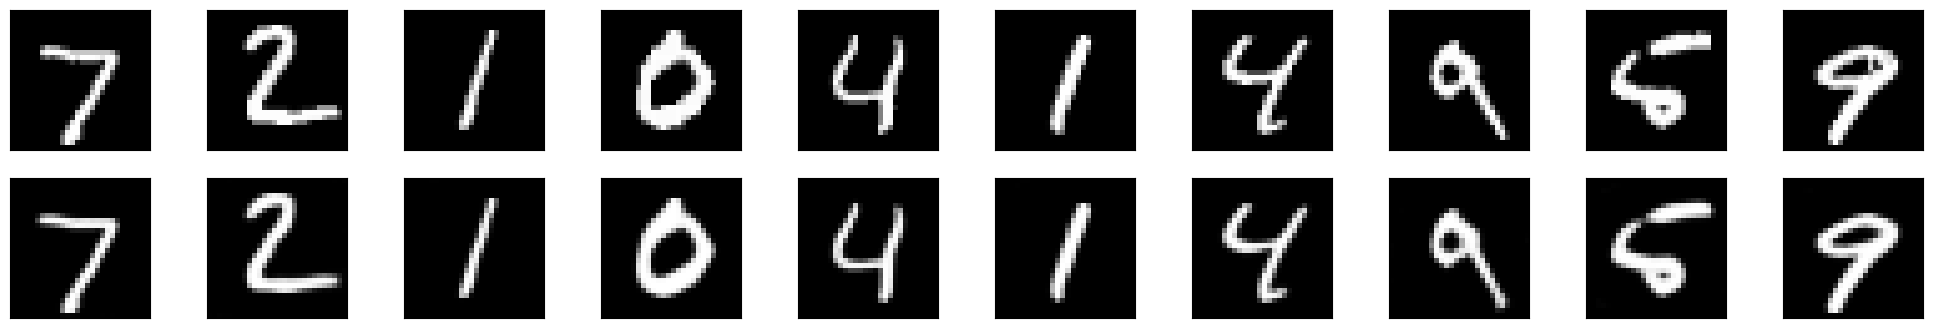

In [17]:
test(model_2, 'conv')  

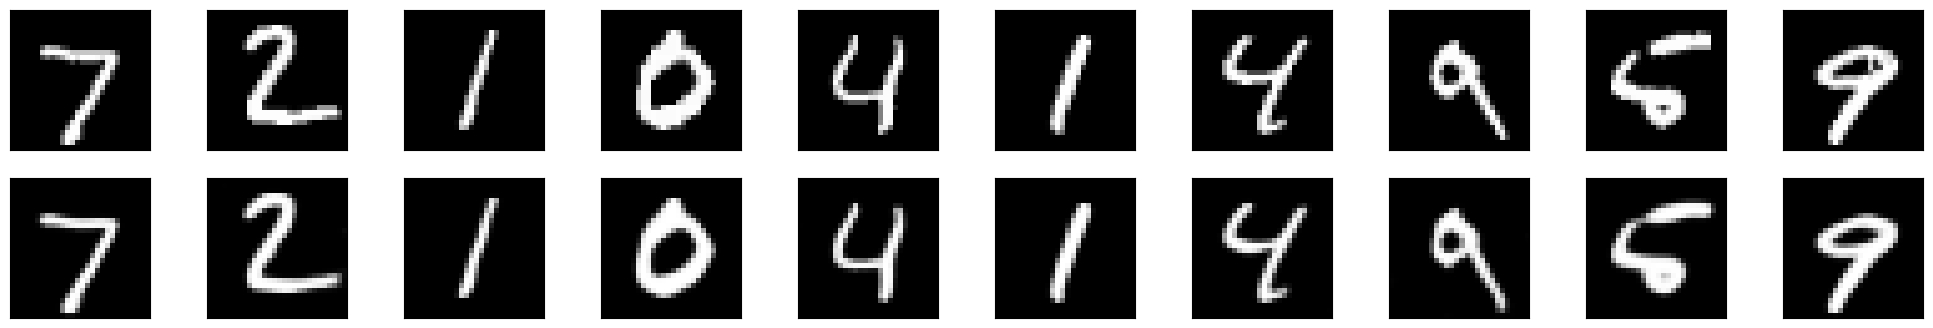

In [18]:
test(model_3, 'conv')

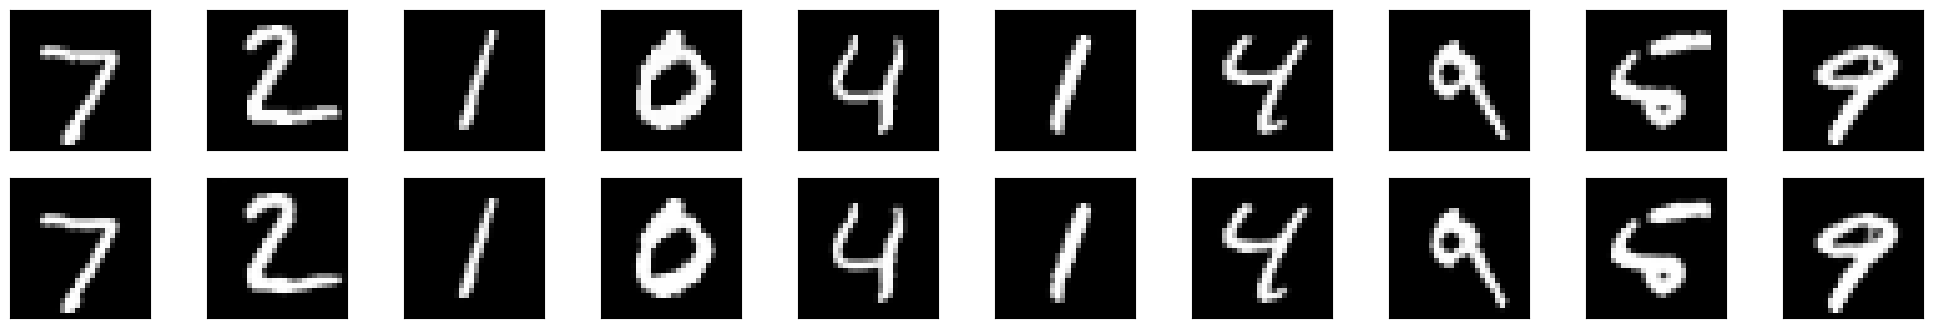

In [19]:
test(model_4,'conv')

## Visualize latent space

In [20]:
# Print Model Summary 
model = model_4

In [21]:
def get_encoder_outputs(model, test_loader, max_batches=None):
    model.eval()
    encoded_images = []
    labels_list = []
    num_batches_processed = 0

    for images, labels in test_loader:
        with torch.no_grad():  # Ensure no gradients are calculated
            encoded_output = model(images)

        # Append the encoded images and corresponding labels to lists
        encoded_images.append(encoded_output.cpu())  # Store on CPU
        labels_list.append(labels)

        num_batches_processed += 1
        if max_batches is not None and num_batches_processed >= max_batches:
            break  # Stop processing after reaching the specified max_batches

    # Concatenate the lists to create tensors for encoded images and labels
    encoded_images = torch.cat(encoded_images, dim=0)
    labels_tensor = torch.cat(labels_list, dim=0)

    return encoded_images, labels_tensor

In [22]:
latents,labels=get_encoder_outputs(model,test_loader,max_batches=50)

### Visualize with PCA

In [23]:
def visualize_latent_space_pca(latents, labels, anchors=None):
    # Convert the 4D latent space to 2D using PCA
    pca = PCA(n_components=2)
    latents_2d = pca.fit_transform(latents.view(latents.size(0), -1).cpu().detach().numpy())

    # Create a DataFrame for easy plotting
    latent_df = pd.DataFrame(latents_2d, columns=['PC1', 'PC2'])
    latent_df['Label'] = labels.numpy()

    # Plot the 2D latent space
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=latent_df, x='PC1', y='PC2', hue='Label', palette='tab10')
    plt.title('2D PCA of Latent Space')
    if anchors is not None:
        # Plot anchors with star marker
        anchors_2d = pca.transform(anchors.view(anchors.size(0), -1).cpu().detach().numpy())
        plt.scatter(anchors_2d[:, 0], anchors_2d[:, 1], marker='*', s=100, c='black')
    plt.show()

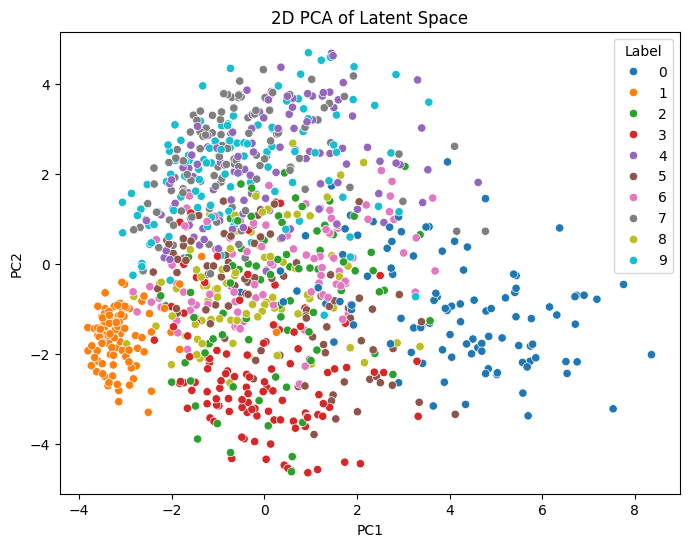

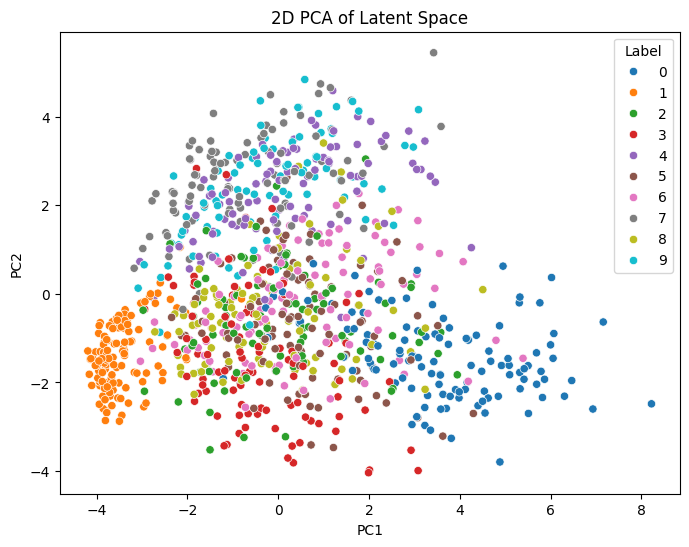

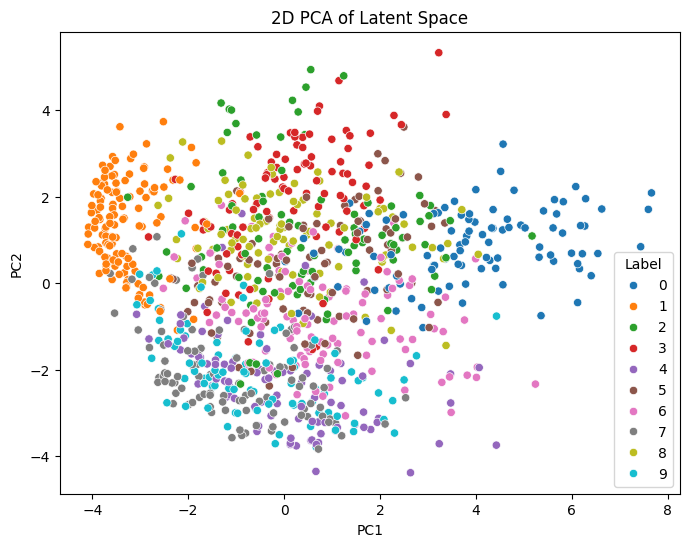

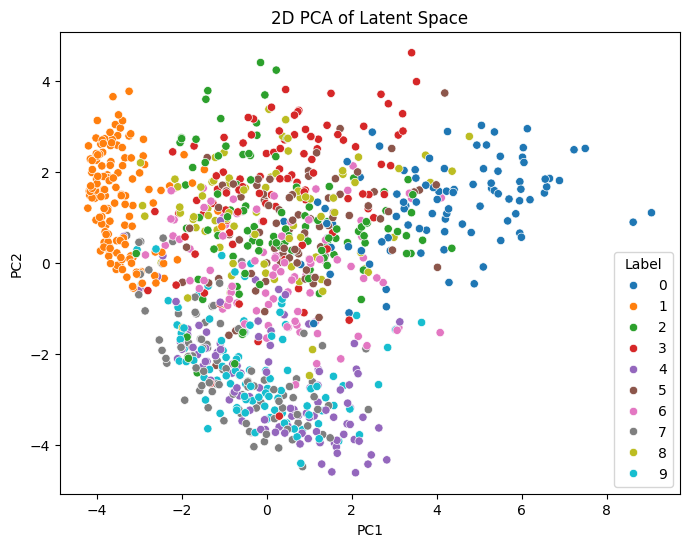

In [24]:
model_1 = LightningAutoencoder.load_from_checkpoint(checkpoint_path='LightningAutoencoder_0.ckpt')
model_2 = LightningAutoencoder.load_from_checkpoint(checkpoint_path='LightningAutoencoder_1.ckpt')
model_3 = LightningAutoencoder.load_from_checkpoint(checkpoint_path='LightningAutoencoder_2.ckpt')


latents_1, labels_1 = get_encoder_outputs(model_1, valid_loader, max_batches=50)
latents_2, labels_2 = get_encoder_outputs(model_2, valid_loader, max_batches=50)
latents_3, labels_3 = get_encoder_outputs(model_3, valid_loader, max_batches=50)
latents_4, labels_4 = get_encoder_outputs(model_4, valid_loader, max_batches=50)

visualize_latent_space_pca(latents_1, labels_1)
visualize_latent_space_pca(latents_2, labels_2)
visualize_latent_space_pca(latents_3, labels_3)
visualize_latent_space_pca(latents_4, labels_4)

### Visualise with t-SNE

In [25]:
#Visualize with tSne
latents_reshaped = latents_1.view(latents_1.shape[0], -1)  # Reshape to [20, 4*7*7]

# Convert to numpy array and apply PCA
latents_np = latents_reshaped.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=1,perplexity=10)
latent_tsne = tsne.fit_transform(latents_np)

# Create a DataFrame for seaborn plotting
latent_df = pd.DataFrame(latent_tsne, columns=['Component 1', 'Component 2'])
latent_df['Label'] = labels_1#.detach().numpy().astype(str)

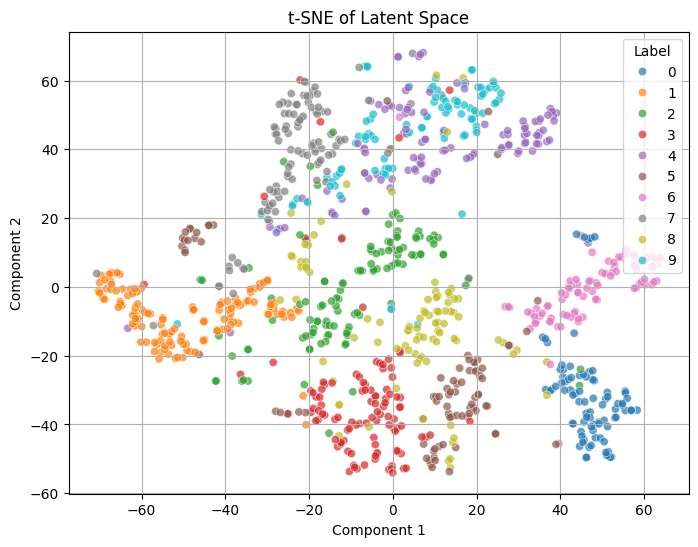

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=latent_df, x='Component 1', y='Component 2', hue='Label', palette='tab10', alpha=0.7)
plt.title('t-SNE of Latent Space')
plt.legend(title='Label', loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
#Visualize with tSne
latents_reshaped = latents_2.view(latents_2.shape[0], -1)  # Reshape to [20, 4*7*7]

# Convert to numpy array and apply PCA
latents_np = latents_reshaped.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=1,perplexity=10)
latent_tsne = tsne.fit_transform(latents_np)

# Create a DataFrame for seaborn plotting
latent_df = pd.DataFrame(latent_tsne, columns=['Component 1', 'Component 2'])
latent_df['Label'] = labels#.detach().numpy().astype(str)

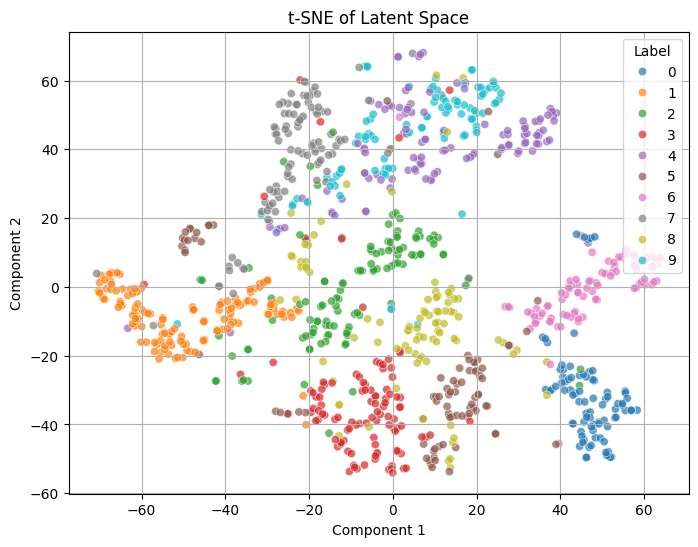

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=latent_df, x='Component 1', y='Component 2', hue='Label', palette='tab10', alpha=0.7)
plt.title('t-SNE of Latent Space')
plt.legend(title='Label', loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
#Visualize with tSne
latents_reshaped = latents_3.view(latents_3.shape[0], -1)  # Reshape to [20, 4*7*7]

# Convert to numpy array and apply PCA
latents_np = latents_reshaped.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=1,perplexity=10)
latent_tsne = tsne.fit_transform(latents_np)

# Create a DataFrame for seaborn plotting
latent_df = pd.DataFrame(latent_tsne, columns=['Component 1', 'Component 2'])
latent_df['Label'] = labels#.detach().numpy().astype(str)

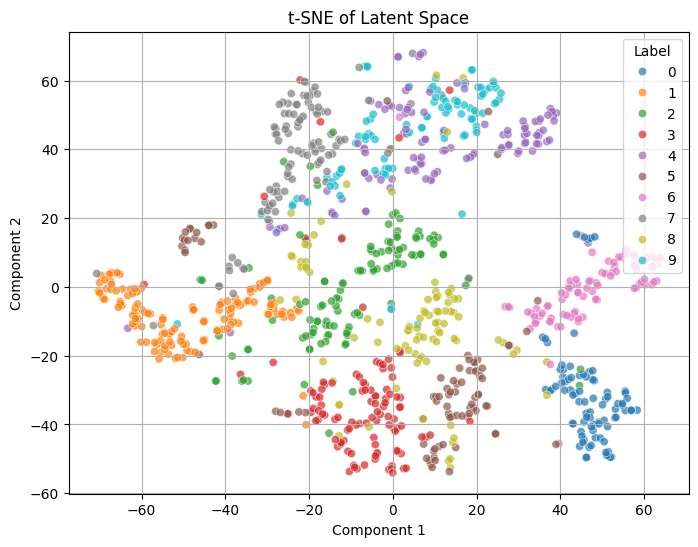

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=latent_df, x='Component 1', y='Component 2', hue='Label', palette='tab10', alpha=0.7)
plt.title('t-SNE of Latent Space')
plt.legend(title='Label', loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
#Visualize with tSne
latents_reshaped = latents_4.view(latents_4.shape[0], -1)  # Reshape to [20, 4*7*7]

# Convert to numpy array and apply PCA
latents_np = latents_reshaped.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=1,perplexity=10)
latent_tsne = tsne.fit_transform(latents_np)

# Create a DataFrame for seaborn plotting
latent_df = pd.DataFrame(latent_tsne, columns=['Component 1', 'Component 2'])
latent_df['Label'] = labels#.detach().numpy().astype(str)

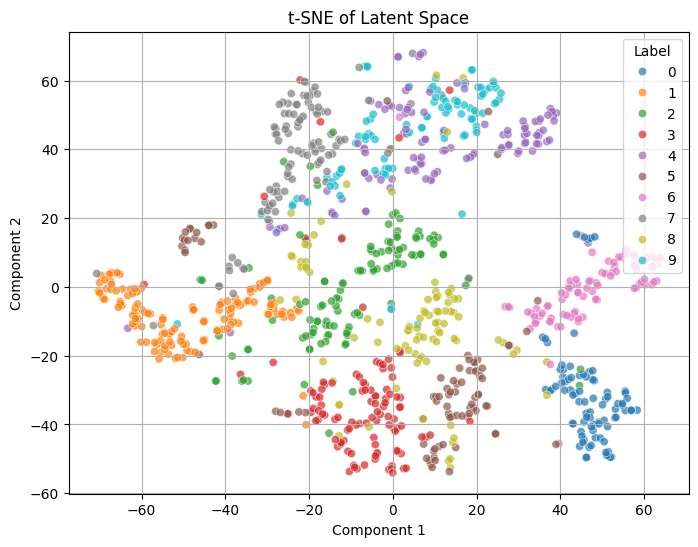

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=latent_df, x='Component 1', y='Component 2', hue='Label', palette='tab10', alpha=0.7)
plt.title('t-SNE of Latent Space')
plt.legend(title='Label', loc='upper right')
plt.grid(True)
plt.show()

## Choose Anchors

In [27]:
from torch.utils.data import SubsetRandomSampler, DataLoader

# Define constants
batch_size = 5
num_workers = 0

# Total number of images in the training dataset
num_images = len(train_data)

# Generate random indices to select 5 random images
random_indices = np.random.choice(num_images, size=5, replace=False)

# Create a subset sampler using the random indices
random_subset_sampler = SubsetRandomSampler(random_indices)

# Create a data loader for the random subset
random_subset_loader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  sampler=random_subset_sampler,
                                  num_workers=num_workers)


In [28]:
dataiter = iter(random_subset_loader)
anchors,anchors_labels = next(dataiter)
anchors_encoded = []
# Get encoding of anchors
for anchor in anchors:
    anchor = anchor.unsqueeze(0)
    anchor_encoded = model(anchor)
    anchors_encoded.append(anchor_encoded)
anchors_encoded = torch.stack(anchors_encoded)

In [29]:
print("Anchors shape {0}".format(anchors.shape))
print("Anchors encoded shape {0}".format(anchors_encoded.shape))

Anchors shape torch.Size([5, 1, 28, 28])
Anchors encoded shape torch.Size([5, 1, 1, 28, 28])


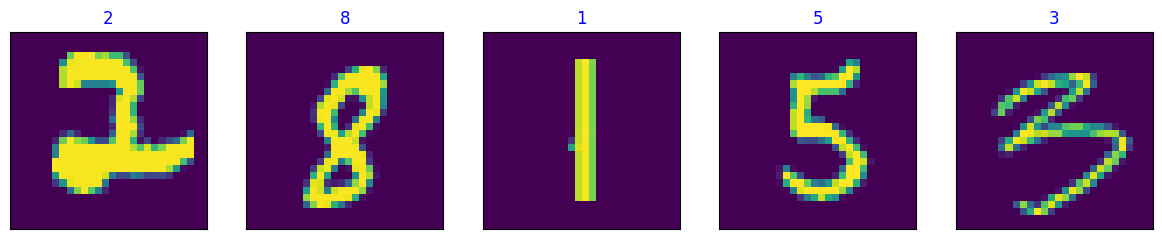

In [30]:
# Displaying the anchors
fig=plt.figure(figsize=(30,10))
for i in range(len(anchors_labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(anchors[i]))
    ax.set_title(anchors_labels[i].item(),color='blue')

## Compute distance and similarity fucntion

In [31]:
from torch import cosine_similarity

In [32]:
def compute_similarity_image(model,anchors,image):
    image_similarities=[]
    image = image.unsqueeze(0)
    image_encoded = model(image).flatten().reshape(1, -1)

    for anchor in anchors:
        anchor = anchor.unsqueeze(0)
        anchor_encoded = model(anchor).flatten().reshape(1, -1)
        print(anchor_encoded.shape)
        print(image_encoded.shape)
        
        similarity = cosine_similarity(anchor_encoded, image_encoded)
        image_similarities.append(similarity.cpu().detach().numpy())
    return image_similarities

def get_similarities(model, data_loader, anchors, max_batches=None):
    model.eval()
    similarities_list=[]
    labels_list = []
    num_batches_processed = 0

    for images, labels in data_loader:
        if torch.cuda.is_available():
            images = images.cuda()

        #Append the computed similiarities for each iamge
        for image in images:
            image_similarities = compute_similarity_image(model,anchors,image)
            similarities_list.append(image_similarities)
        labels_list.append(labels)

        num_batches_processed += 1
        if max_batches is not None and num_batches_processed >= max_batches:
            break  # Stop processing after reaching the specified max_batches

    # Concatenate the lists to create tensors for encoded images and labels
    similarities  = torch.tensor(similarities_list)
    labels = torch.cat(labels_list, dim=0)

    return similarities, labels


In [33]:
similarities,similarity_labels = get_similarities(model,train_loader,anchors,10)

torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1

/var/folders/tp/9l7ncvh137x08kdlp_fvr1nw0000gn/T/ipykernel_53136/1649291619.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  similarities  = torch.tensor(similarities_list)


In [34]:
#Get the similarities for the anchors
anchor_similarities = []
for anchor in anchors:  
    image_similarities = compute_similarity_image(model,anchors,anchor)
    anchor_similarities.append(image_similarities)
anchor_similarities = torch.tensor(anchor_similarities)

torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1, 784])
torch.Size([1

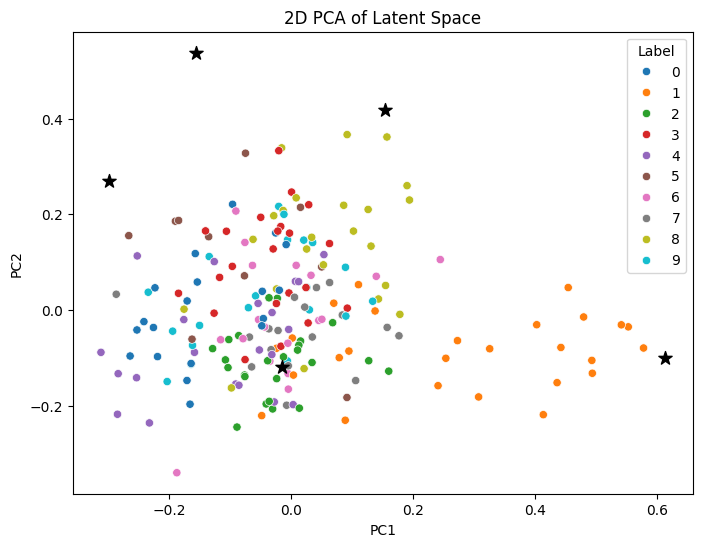

In [35]:
visualize_latent_space_pca(similarities,similarity_labels,anchor_similarities)

In [36]:
def compare_models(model1, model2):
    for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
        if name1 != name2:
            print(f"Parameter name mismatch: {name1} vs {name2}")
            return False
        if not torch.equal(param1.data, param2.data):
            print(f"Parameter values mismatch at {name1}")
            return False
    return True

model_1 = LightningAutoencoder.load_from_checkpoint(checkpoint_path='LightningAutoencoder_0.ckpt')
model_2 = LightningAutoencoder.load_from_checkpoint(checkpoint_path='LightningAutoencoder_1.ckpt')
model_3 = LightningAutoencoder.load_from_checkpoint(checkpoint_path='LightningAutoencoder_2.ckpt')

print("Comparing model_1 and model_2:", compare_models(model_1, model_2))
print("Comparing model_1 and model_3:", compare_models(model_1, model_3))
print("Comparing model_2 and model_3:", compare_models(model_2, model_3))


Parameter values mismatch at autoencoder.encoder.0.0.weight
Comparing model_1 and model_2: False
Parameter values mismatch at autoencoder.encoder.0.0.weight
Comparing model_1 and model_3: False
Parameter values mismatch at autoencoder.encoder.0.0.weight
Comparing model_2 and model_3: False
